# Cervical Spine Fracture Detection
This notebook aims at building a deep learning pipeline to detect fractures in CT-scans of the cervical spine spanning from C1 to C7, encompassing seven distinct categories. 
We will employ various python libraries such as matplotlib, numpy and Google's Tensorflow DL framework for this notebook as it also supports Keras.

**NOTE:** The dataset contains additional data such as bounding boxes which will be useful in building more robust models but we are not going to utilize that for this notebook. However, we will be using only images whose segmentations are available for our use.

### 1. Problem
To build an end-to-end multilabel image classifier which can identify the CT-scan images for cervical spine fractures in C1-C7 categories with respective probabilities.

### 2. Data
The data we're using is from Kaggle's RSNA 2k22 Cervical Spine Fracture Detection competition. For more information...  
https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/data

### 3. Evaluation
The evaluation metric for the predictions is binary weighted log loss function. It is the ratio of predictions our model got right and the total predictions made.

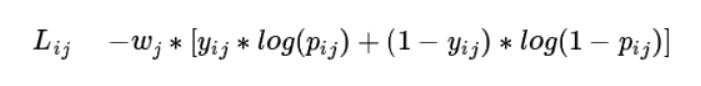

For more information...https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/overview

In [1]:
#During submission internet is disabled. Hence install this package manually
!pip install -qU ../input/for-pydicom/python_gdcm-3.0.22-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl ../input/for-pydicom/pylibjpeg-1.4.0-py3-none-any.whl --find-links frozen_packages --no-index

In [1]:
import pandas as pd
import numpy as np
import pydicom as dicom
import glob
import nibabel as nib
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, callbacks
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import InceptionV3, DenseNet121, InceptionResNetV2

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical, plot_model
from keras.preprocessing import image

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix
pd.set_option('display.max_columns', None)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 1. Import libraries and load datasets

In [2]:
base_dir = r'/kaggle/input/rsna-2022-cervical-spine-fracture-detection'
train_images = os.path.join(base_dir,'train_images')
test_images = os.path.join(base_dir,'test_images')
train_df = pd.read_csv(os.path.join(base_dir,'train.csv'))
segmentation_meta_data = pd.read_csv(r'/kaggle/input/rsna-cervical-fracture-segmentation-metadata/meta_segmentation.csv')

In [3]:
segmentation_meta_data

,Rows,Columns,SOPInstanceUID,ContentDate,SliceThickness,InstanceNumber,ImagePositionPatientX,ImagePositionPatientY,ImagePositionPatientZ,PhotometricInterpretation,PixelSpacingX,PixelSpacingY,WindowCenter,WindowWidth,RescaleIntercept,RescaleSlope,StudyInstanceUID,C1,C2,C3,C4,C5,C6,C7,Slice,SliceRatio
0,512,512,1.2.826.0.1.3680043.1363.1.12,20220727,1.000,12,-149.208008,-350.208008,65.000,MONOCHROME2,0.583984,0.583984,"[450, 40]","[1500, 350]",-1024,1,1.2.826.0.1.3680043.1363,0,0,0,0,0,0,0,11.0,0.055556
1,512,512,1.2.826.0.1.3680043.1363.1.120,20220727,1.000,120,-149.208008,-350.208008,173.000,MONOCHROME2,0.583984,0.583984,"[450, 40]","[1500, 350]",-1024,1,1.2.826.0.1.3680043.1363,0,0,0,0,1,1,0,119.0,0.601010
2,512,512,1.2.826.0.1.3680043.1363.1.141,20220727,1.000,141,-149.208008,-350.208008,194.000,MONOCHROME2,0.583984,0.583984,"[450, 40]","[1500, 350]",-1024,1,1.2.826.0.1.3680043.1363,0,0,0,0,0,1,1,140.0,0.707071
3,512,512,1.2.826.0.1.3680043.1363.1.18,20220727,1.000,18,-149.208008,-350.208008,71.000,MONOCHROME2,0.583984,0.583984,"[450, 40]","[1500, 350]",-1024,1,1.2.826.0.1.3680043.1363,0,0,0,0,0,0,0,17.0,0.085859
4,512,512,1.2.826.0.1.3680043.1363.1.9,20220727,1.000,9,-149.208008,-350.208008,62.000,MONOCHROME2,0.583984,0.583984,"[450, 40]","[1500, 350]",-1024,1,1.2.826.0.1.3680043.1363,0,0,0,0,0,0,0,8.0,0.040404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29827,512,512,1.2.826.0.1.3680043.26990.1.26,20220727,0.625,26,-84.500000,-61.100000,-14.060,MONOCHROME2,0.310547,0.310547,550,2000,-1024,1,1.2.826.0.1.3680043.26990,0,0,0,0,0,0,0,25.0,0.103734
29828,512,512,1.2.826.0.1.3680043.26990.1.185,20220727,0.625,185,-84.500000,-61.100000,-113.435,MONOCHROME2,0.310547,0.310547,550,2000,-1024,1,1.2.826.0.1.3680043.26990,0,0,0,0,0,1,1,184.0,0.763485
29829,512,512,1.2.826.0.1.3680043.26990.1.221,20220727,0.625,221,-84.500000,-61.100000,-135.935,MONOCHROME2,0.310547,0.310547,550,2000,-1024,1,1.2.826.0.1.3680043.26990,0,0,0,0,0,0,0,220.0,0.912863
29830,512,512,1.2.826.0.1.3680043.26990.1.13,20220727,0.625,13,-84.500000,-61.100000,-5.935,MONOCHROME2,0.310547,0.310547,550,2000,-1024,1,1.2.826.0.1.3680043.26990,0,0,0,0,0,0,0,12.0,0.049793


In [4]:
segmentation_meta_data.shape

(29832, 26)

In [5]:
segmentation_meta_data.columns

Index(['Rows', 'Columns', 'SOPInstanceUID', 'ContentDate', 'SliceThickness',
       'InstanceNumber', 'ImagePositionPatientX', 'ImagePositionPatientY',
       'ImagePositionPatientZ', 'PhotometricInterpretation', 'PixelSpacingX',
       'PixelSpacingY', 'WindowCenter', 'WindowWidth', 'RescaleIntercept',
       'RescaleSlope', 'StudyInstanceUID', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6',
       'C7', 'Slice', 'SliceRatio'],
      dtype='object')

## 2. Data Processing
In this notebook, we'll include only those images whose segmentations are available and will process them for modelling.

In [6]:
columns = ['StudyInstanceUID','SOPInstanceUID','C1','C2','C3','C4','C5','C6','C7']
seg_labels = segmentation_meta_data[columns]
seg_labels.head(2)

,StudyInstanceUID,SOPInstanceUID,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.1363,1.2.826.0.1.3680043.1363.1.12,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.1363,1.2.826.0.1.3680043.1363.1.120,0,0,0,0,1,1,0


In [7]:
#Get Slice instance number
seg_labels.loc[:,'slice'] = seg_labels['SOPInstanceUID'].apply(lambda x:x.split('.')[-1])
seg_labels

/tmp/ipykernel_360/1938975322.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seg_labels.loc[:,'slice'] = seg_labels['SOPInstanceUID'].apply(lambda x:x.split('.')[-1])


,StudyInstanceUID,SOPInstanceUID,C1,C2,C3,C4,C5,C6,C7,slice
0,1.2.826.0.1.3680043.1363,1.2.826.0.1.3680043.1363.1.12,0,0,0,0,0,0,0,12
1,1.2.826.0.1.3680043.1363,1.2.826.0.1.3680043.1363.1.120,0,0,0,0,1,1,0,120
2,1.2.826.0.1.3680043.1363,1.2.826.0.1.3680043.1363.1.141,0,0,0,0,0,1,1,141
3,1.2.826.0.1.3680043.1363,1.2.826.0.1.3680043.1363.1.18,0,0,0,0,0,0,0,18
4,1.2.826.0.1.3680043.1363,1.2.826.0.1.3680043.1363.1.9,0,0,0,0,0,0,0,9
...,...,...,...,...,...,...,...,...,...,...
29827,1.2.826.0.1.3680043.26990,1.2.826.0.1.3680043.26990.1.26,0,0,0,0,0,0,0,26
29828,1.2.826.0.1.3680043.26990,1.2.826.0.1.3680043.26990.1.185,0,0,0,0,0,1,1,185
29829,1.2.826.0.1.3680043.26990,1.2.826.0.1.3680043.26990.1.221,0,0,0,0,0,0,0,221
29830,1.2.826.0.1.3680043.26990,1.2.826.0.1.3680043.26990.1.13,0,0,0,0,0,0,0,13


### 2.1 Custom utility functions
We'll write some utility functions to assist us in loading and generating batches of images and labels. Further also some additions to visualize the final scores on the test data.

In [8]:
def load_dicom(path):
    '''
    Function to load and transform DICOM images.
    
    Parameters:
    path(string): Path to the DICOM images

    Returns:
    Transformed and resized image.
    
    '''
    img=dicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
    data=img.pixel_array
    data=data-np.min(data)
    if np.max(data) != 0:
        data=data/np.max(data)
    data=(data*255).astype(np.uint8)        
    return cv2.cvtColor(data.reshape(512, 512), cv2.COLOR_GRAY2RGB)

def ImgDataGenerator(train_df,base_path):
    '''
    Function to read dicom image path and store the images as numpy arrays.

    Parameters:
    train_df: Pandas dataframe.
    base_path: Python list containing image filepaths.

    Returns:
    [Train image dataset, Train image labels]

    '''
    trainset = []
    trainlabel = []
    for i in tqdm(range(len(train_df))):
        study_id = train_df.loc[i,'StudyInstanceUID']
        slice_id = train_df.loc[i,'slice']+'.dcm'
        study_path = study_id+'/'+slice_id

        path = os.path.join(base_path, study_path)

        img = load_dicom(path)
        img = cv2.resize(img, (128 , 128))
        image = img_to_array(img)
        image = image / 255.0
        trainset += [image]
        cur_label = [train_df.loc[i,f'C{j}'] for j in range(1,8)]
        trainlabel += [cur_label]

    return np.array(trainset), np.array(trainlabel)
    
def metrics(y_test, y_pred_binary):
    '''
    Function to display accuracy, precision, recall and f1-score for the classification task.
    
    Parameters:
    y_test: True labels.
    y_pred_binary: Predicted binary labels.

    Returns:
    Pandas dataframe containing class-wise Sensitivity, Specificity, and F1-score.
    
    '''
    classes = np.array(seg_labels.columns[2:-1])
    df_res = []
    precision_per_class = precision_score(y_test, y_pred_binary, average=None)
    recall_per_class = recall_score(y_test, y_pred_binary, average=None)
    f1_per_class = f1_score(y_test, y_pred_binary, average=None)

    for i in range(len(classes)):
        df_res.append([classes[i], recall_per_class[i], precision_per_class[i], f1_per_class[i]])
    df_res = pd.DataFrame(df_res, columns = ['Class','Sensitivity','Specificity', 'F1-score'])
    return df_res

def plot_history(history):
    '''
    Function to plot the train and validation accuracy and loss.
    
    Parameters:
    history: model train history

    Returns:
    None.
    
    '''
    hist = history.history
    plt.figure(figsize=(8, 4));
    plt.suptitle(f"Performance Metrics", fontsize=12)

    # Actual and validation losses
    plt.subplot(1, 2, 1);
    plt.plot(hist['loss'], label='train')
    plt.plot(hist['val_loss'], label='validation')
    plt.title('Train and val loss curve', fontsize=8)
    plt.legend()

    # Actual and validation accuracy
    plt.subplot(1, 2, 2);
    plt.plot(hist['binary_accuracy'], label='train')
    plt.plot(hist['val_binary_accuracy'], label='validation')
    plt.title('Train and val accuracy curve', fontsize=8)
    plt.legend();
    
def callback(model_name, patience=5): 
    '''
    Function to define callback for model training.
    
    Parameters:
    model_name(string): Name for the saved model with `.h5` extension.
    patience: Patience for early stopping. Usually, the value lies between 5-11.

    Returns:
    [Early Stopping Callback, Model Checkpoint Callback]
    
    '''
    early_stopping = callbacks.EarlyStopping(patience=patience, restore_best_weights=True)
    model_checkpoint = callbacks.ModelCheckpoint(model_name, save_best_only=True)
    return [early_stopping, model_checkpoint]

In [9]:
# Convert train images of segmented studyids to array
X_seg, y_seg = ImgDataGenerator(seg_labels,train_images)
X_seg.shape,y_seg.shape

100%|██████████| 29832/29832 [08:51<00:00, 56.08it/s]


((29832, 128, 128, 3), (29832, 7))

In [11]:
# save for future use
# np.save('/kaggle/working/seg_train_images.npy',X_seg)
# np.save('/kaggle/working/seg_train_images_labels.npy',y_seg)

# #Uncomment this if you want to use the above output in the next run
# #X_seg = np.load(r'/kaggle/input/identify-vertbrae-using-cnn/seg_train_images.npy')
# #y_seg = np.load(r'/kaggle/input/identify-vertbrae-using-cnn/seg_train_images_labels.npy')

/opt/conda/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[0 0 1 1 0 0 0]')

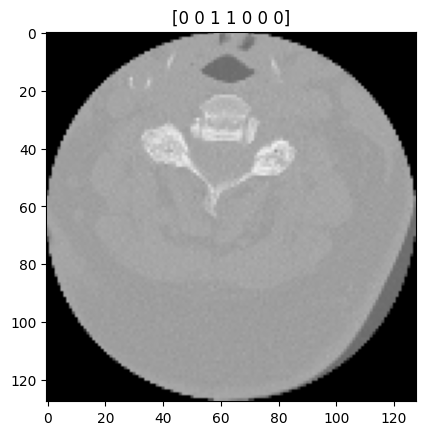

In [10]:
# Visualize a random CT scan image
plt.imshow(X_seg[500], cmap = 'bone')
plt.title(y_seg[500]) # The above slice represents cervicals C3 and C4

In [11]:
# Divide train and test data
X_train, X_test, y_train, y_test = train_test_split(X_seg, y_seg, random_state=42, test_size=0.1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((26848, 128, 128, 3), (26848, 7), (2984, 128, 128, 3), (2984, 7))

In [12]:
# Prepare data batches for training images
X_train_tensor = tf.data.Dataset.from_tensor_slices(X_train)
y_train_tensor = tf.data.Dataset.from_tensor_slices(y_train)
train_dataset = tf.data.Dataset.zip((X_train_tensor, y_train_tensor)).batch(16).prefetch(tf.data.AUTOTUNE)
# Prepare data batches for validation images
X_test_tensor = tf.data.Dataset.from_tensor_slices(X_test)
y_test_tensor = tf.data.Dataset.from_tensor_slices(y_test)
val_dataset = tf.data.Dataset.zip((X_test_tensor, y_test_tensor)).batch(16).prefetch(tf.data.AUTOTUNE)

## 3. Modelling
We'll opt for three different modelling approaches:
1. **Custom CNN** - Here we will implement our own custom CNN model from scratch involving blocks of Convolution, Pooling and DropOut layers.
2. **Transfer Learning models** - In this section, we will employ various pre-trained deep learning models to further improve on the results of the Custom CNN model.
3. **Encoder decoder Architecture** - Finally, we will implement an encoder-decoder model where we will use the U-Net model for encoder and the best performing transfer learning model as a decoder. 

### 3.1. Encoder decoder Architecture

In [13]:
def conv_block(input, num_filters):
    '''
    Function for convolution block unit.
    
    Parameters:
    input(keras layer): Input layer.
    num_filters(int): Number of filters in the Conv2D layer. 

    Returns:
    Final convoluted and activated output layer.
    
    '''
    x = layers.Conv2D(num_filters, 3, padding="same")(input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(num_filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    '''
    Function for convolution block unit.
    
    Parameters:
    input(keras layer): Input layer.
    num_filters(int): Number of filters in the Conv2D layer. 

    Returns:
    Final convoluted and activated output layer.
    
    '''
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_inception_resnetv2_unet(input_shape):
    # Input layer
    inputs = layers.Input(input_shape)
    
    # Pre-trained transfer learning model
    encoder = InceptionResNetV2(include_top=False, weights="imagenet", input_tensor=inputs)

    # Encoder
    s1 = encoder.get_layer("input_1").output           ## (512 x 512)
    s2 = encoder.get_layer("activation").output        ## (255 x 255)
    s2 = layers.ZeroPadding2D(( (1, 0), (1, 0) ))(s2)         ## (256 x 256)
    s3 = encoder.get_layer("activation_3").output      ## (126 x 126)
    s3 = layers.ZeroPadding2D((1, 1))(s3)                     ## (128 x 128)
    s4 = encoder.get_layer("activation_74").output      ## (61 x 61)
    s4 = layers.ZeroPadding2D(( (2, 1),(2, 1) ))(s4)           ## (64 x 64)

    # Bridge
    b1 = encoder.get_layer("activation_161").output     ## (30 x 30)
    b1 = layers.ZeroPadding2D((1, 1))(b1)                      ## (32 x 32)

    # Decoder layer
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)
    
    # Output layer
    gap = layers.GlobalAveragePooling2D()(d4)
    dropout = layers.Dropout(0.2)(gap)
    outputs = layers.Dense(7, activation="sigmoid")(dropout)
    # Build the model
    model = Model(inputs, outputs, name="InceptionResNetV2-UNet")
    
    return model

model_0 = build_inception_resnetv2_unet(input_shape = (128, 128, 3))

219055592/219055592 [==============================] - 8s 0us/step


In [14]:
model_0.summary()

Model: "InceptionResNetV2-UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 63, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                             

In [15]:
# Compile the model
model_0.compile(loss="binary_crossentropy",
              optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

# Train the model
history_model_0 = model_0.fit(train_dataset, 
                              epochs=50, 
                              validation_data=val_dataset,
                              steps_per_epoch=int(len(train_dataset)/32),
                              validation_steps=int(len(val_dataset)),
                              callbacks=[callback(patience=9, model_name="model_0_InceptionResNetV2.h5")])

Epoch 1/50
52/52 [==============================] - 114s 438ms/step - loss: 0.5474 - binary_accuracy: 0.7838 - val_loss: 0.6672 - val_binary_accuracy: 0.8187
Epoch 2/50
52/52 [==============================] - 18s 358ms/step - loss: 0.4327 - binary_accuracy: 0.8499 - val_loss: 0.5875 - val_binary_accuracy: 0.8616
Epoch 3/50
52/52 [==============================] - 18s 357ms/step - loss: 0.3749 - binary_accuracy: 0.8802 - val_loss: 0.4503 - val_binary_accuracy: 0.8783
Epoch 4/50
52/52 [==============================] - 16s 305ms/step - loss: 0.3462 - binary_accuracy: 0.8875 - val_loss: 0.4666 - val_binary_accuracy: 0.8919
Epoch 5/50
52/52 [==============================] - 16s 305ms/step - loss: 0.3191 - binary_accuracy: 0.9001 - val_loss: 0.7053 - val_binary_accuracy: 0.8963
Epoch 6/50
52/52 [==============================] - 16s 305ms/step - loss: 0.2954 - binary_accuracy: 0.9138 - val_loss: 1.2794 - val_binary_accuracy: 0.9250
Epoch 7/50
52/52 [==============================] - 16s 3

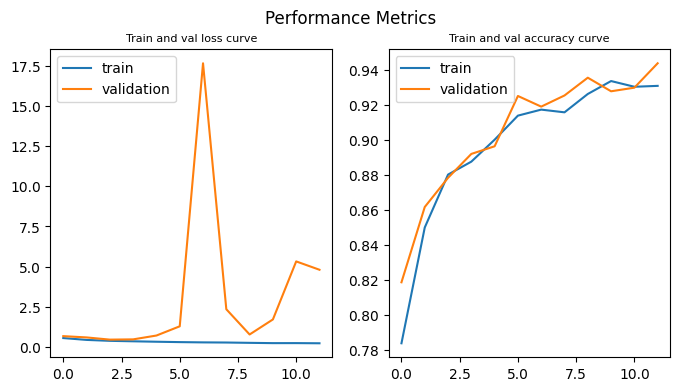

In [16]:
# Visualize the accuracy and loss for model training per epoch
plot_history(history_model_0)

In [17]:
# Get the class-wise scores on the test data
y_pred_0 = model_0.predict(X_test)
threshold = 0.4
y_pred_binary_0 = (y_pred_0 > threshold).astype(int)
score_0 = model_0.evaluate(X_test, y_test, verbose = 1)
df_met_model_0 = metrics(y_test, y_pred_binary_0)
print(f'Test loss:{score_0[0]}\n Test accuracy:{score_0[1]}')
df_met_model_0

94/94 [==============================] - 7s 74ms/step - loss: 0.4503 - binary_accuracy: 0.8783
Test loss:0.45027658343315125
 Test accuracy:0.8783033490180969


,Class,Sensitivity,Specificity,F1-score
0,C1,0.825000,0.510046,0.630372
1,C2,0.899390,0.584158,0.708283
2,C3,0.997613,0.305332,0.467562
3,C4,0.945498,0.535570,0.683805
4,C5,0.933036,0.446581,0.604046
5,C6,0.809111,0.472152,0.596323
6,C7,0.934827,0.348519,0.507743


#### Predictions on the test data

In [18]:
img = X_test[17]
proba = model_0.predict(img.reshape(1,128,128,3))
# Fetches the probability value for each class in a sorted order
np.argsort(proba[0])

1/1 [==============================] - 1s 621ms/step


array([1, 0, 3, 2, 4, 5, 6])

### 3.2. Custom CNN model

In [ ]:
# input_layer = layers.Input((128, 128 ,3))
# x = layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
# x = layers.MaxPooling2D((2, 2))(x)
# x = layers.Conv2D(64, (3, 3), activation='relu')(x)
# x = layers.MaxPooling2D((2, 2))(x)
# x = layers.Conv2D(128, (3, 3), activation='relu')(x)
# x = layers.MaxPooling2D((2, 2))(x)
# x = layers.Flatten()(x)
# x = layers.Dense(128, 'relu')(x)
# x = layers.Dropout(0.5)(x)
# output_layer = layers.Dense(7, 'sigmoid')(x)
# # Build the model
# model_1 = tf.keras.models.Model(input_layer, output_layer)

# # Compile the model
# model_1.compile(loss="binary_crossentropy",
#               optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
#               metrics=[tf.keras.metrics.BinaryAccuracy()])

# model_1.summary()

In [ ]:
# # Train the model
# history_model_1 = model_1.fit(X_train, 
#                           y_train, 
#                           epochs=100, 
#                           validation_data=(X_test, y_test), 
#                           batch_size=64,
#                           callbacks=[callback(patience=9, model_name="model_1_custom_CNN.h5")])

In [ ]:
# # Visualize the accuracy and loss for model training per epoch
# plot_history(history_model_1)

In [ ]:
# # Get the class-wise scores on the test data
# y_pred_1 = model_1.predict(X_test)
# threshold = 0.4
# y_pred_binary_1 = (y_pred_1 > threshold).astype(int)
# score_1 = model_1.evaluate(X_test, y_test, verbose = 1)
# df_met_model_1 = metrics(y_test, y_pred_binary_1)
# print(f'Test loss:{score_1[0]}\n Test accuracy:{score_1[1]}')
# df_met_model_1

### 3.3. Transfer learning models
#### 3.3.1 DenseNet121

In [ ]:
base_model_2 = DenseNet121(include_top=False, input_shape=(128, 128, 3))
model_2 = Sequential()
model_2.add(base_model_2)
model_2.add(layers.GlobalAveragePooling2D())
model_2.add(layers.Dropout(0.2))
model_2.add(layers.Dense(7, activation='sigmoid'))
# Summary of the model
model_2.summary()

# Compile the model
model_2.compile(loss="binary_crossentropy",
              optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [ ]:
# Train the model
history_model_2 = model_2.fit(train_dataset, 
                              epochs=50, 
                              validation_data=val_dataset,
                              steps_per_epoch=int(len(train_dataset)/32),
                              validation_steps=int(len(val_dataset)),
                              callbacks=[callback(patience=9, model_name="model_2_denseNet121.h5")])

In [ ]:
# Visualize the accuracy and loss for model training per epoch
plot_history(history_model_2)

In [ ]:
# Get the class-wise scores on the test data
y_pred_2 = model_2.predict(X_test)
threshold = 0.4
y_pred_binary_2 = (y_pred_2 > threshold).astype(int)
score_2 = model_2.evaluate(X_test, y_test, verbose = 1)
df_met_model_2 = metrics(y_test, y_pred_binary_2)
print(f'Test loss:{score_2[0]}\n Test accuracy:{score_2[1]}')
df_met_model_2

#### 3.3.2 InceptionV3

In [ ]:
base_model_3 = InceptionV3(include_top=False, input_shape=(128, 128, 3))
model_3 = Sequential()
model_3.add(base_model_3)
model_3.add(layers.GlobalAveragePooling2D())
model_3.add(layers.Dropout(0.2))
model_3.add(layers.Dense(7, activation='sigmoid'))
# Summary of the model
model_3.summary()

# Compile the model
model_3.compile(loss="binary_crossentropy",
              optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [ ]:
# Train the model
history_model_3 = model_3.fit(train_dataset, 
                              epochs=50, 
                              validation_data=val_dataset,
                              steps_per_epoch=int(len(train_dataset)/32),
                              validation_steps=int(len(val_dataset)),
                              callbacks=[callback(patience=9, model_name="model_3_inceptionV3.h5")])

In [ ]:
# Visualize the accuracy and loss for model training per epoch
plot_history(history_model_3)

In [ ]:
# Get the class-wise scores on the test data
y_pred_3 = model_3.predict(X_test)
threshold = 0.4
y_pred_binary_3 = (y_pred_3 > threshold).astype(int)
score_3 = model_3.evaluate(X_test, y_test, verbose = 1)
df_met_model_3 = metrics(y_test, y_pred_binary_3)
print(f'Test loss:{score_3[0]}\n Test accuracy:{score_3[1]}')
df_met_model_3

#### 3.3.3 InceptionResNetV2

In [ ]:
base_model_4 = InceptionV3(include_top=False, input_shape=(128, 128, 3))
model_4 = Sequential()
model_4.add(base_model_4)
model_4.add(layers.GlobalAveragePooling2D())
model_4.add(layers.Dropout(0.2))
model_4.add(layers.Dense(7, activation='sigmoid'))
# Summary of the model
model_4.summary()

# Compile the model
model_4.compile(loss="binary_crossentropy",
              optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [ ]:
# Train the model
history_model_4 = model_4.fit(train_dataset, 
                              epochs=50, 
                              validation_data=val_dataset,
                              steps_per_epoch=int(len(train_dataset)/32),
                              validation_steps=int(len(val_dataset)),
                              callbacks=[callback(patience=9, model_name="model_4_InceptionResNetV2.h5")])

In [ ]:
# Visualize the accuracy and loss for model training per epoch
plot_history(history_model_4)

In [ ]:
# Get the class-wise scores on the test data
y_pred_4 = model_4.predict(X_test)
threshold = 0.4
y_pred_binary_4 = (y_pred_4 > threshold).astype(int)
score_4 = model_4.evaluate(X_test, y_test, verbose = 1)
df_met_model_4 = metrics(y_test, y_pred_binary_4)
print(f'Test loss:{score_4[0]}\n Test accuracy:{score_4[1]}')
df_met_model_4

## 4. Predictions on test data 